17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing



Evaluation on test set:
MAE: 18460.73
RMSE: 21648.26


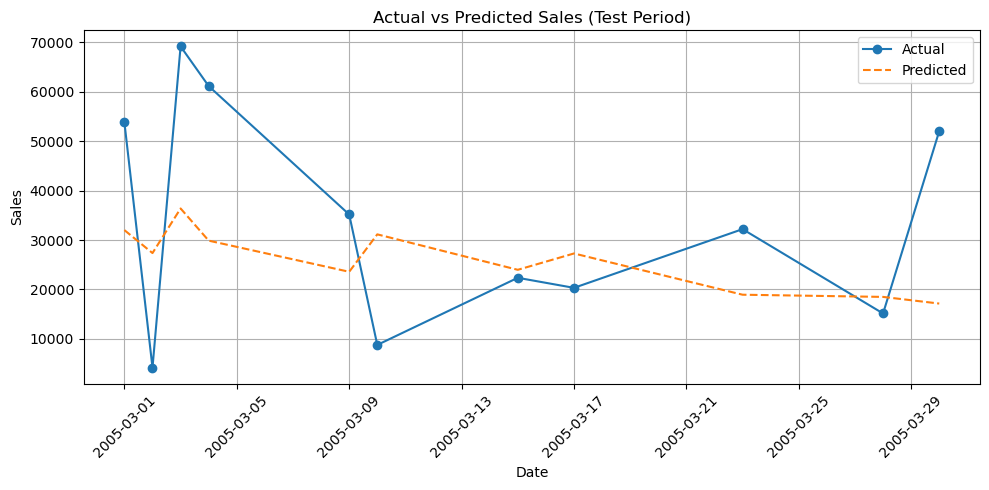

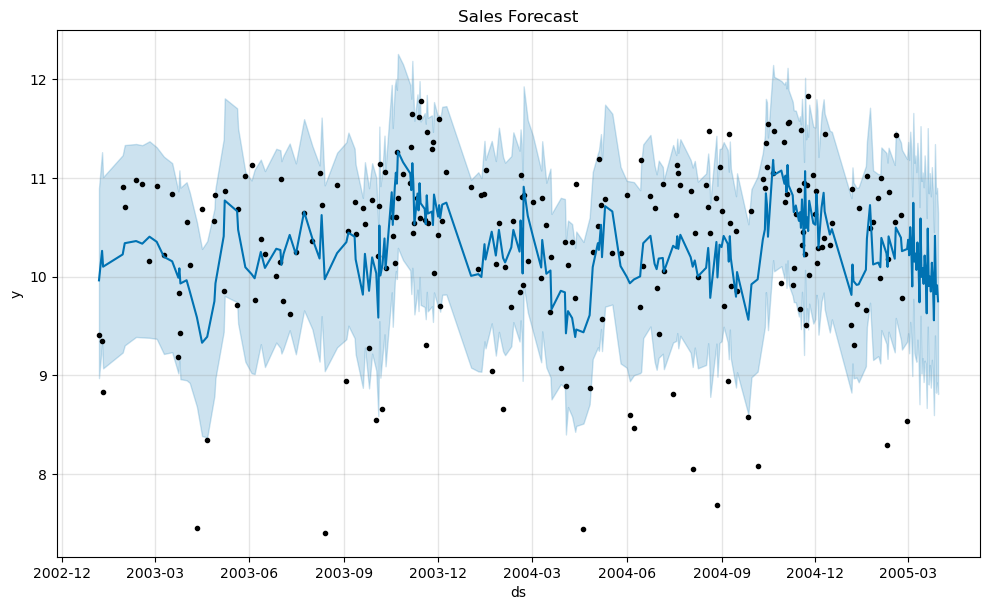

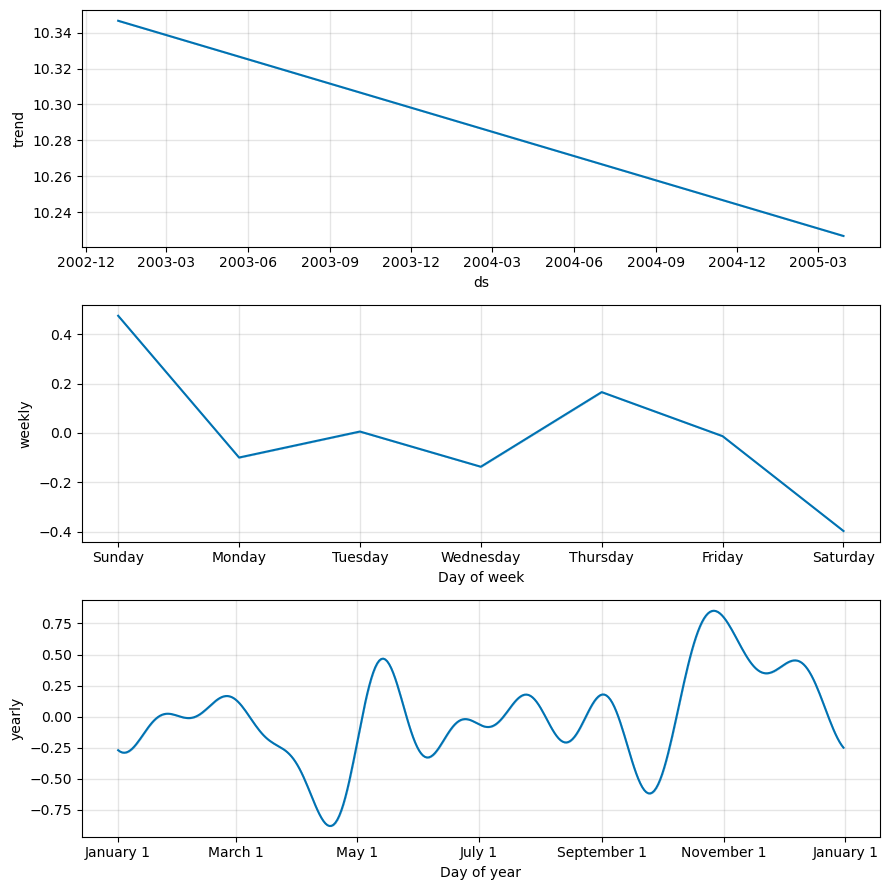

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Running cross-validation (this may take a moment)...


  0%|          | 0/20 [00:00<?, ?it/s]

17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:35 - cmdstanpy - INFO - Chain [1]


Cross-validation metrics summary:
  horizon       mae      rmse     mdape     smape  coverage
0  3 days  1.573143  2.514288  0.090155  0.168866  0.569444
1  4 days  1.120439  2.084726  0.039014  0.108282  0.817460
2  5 days  1.649909  2.895524  0.069518  0.144207  0.611111
3  6 days  1.708121  2.793059  0.112394  0.151852  0.475309
4  7 days  2.724415  6.177061  0.086284  0.182062  0.481481


In [39]:
# Install required packages
# !pip install pandas matplotlib prophet scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# --- Load & preprocess data ---
df = pd.read_csv('sales_data_sample.csv', encoding='latin1')
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# Group by date and sum the sales
df_grouped = df.groupby('ORDERDATE').agg({'SALES': 'sum'}).reset_index()
df_grouped.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)

# --- (Optional) Log-transform target variable ---
use_log = True
if use_log:
    df_grouped['y'] = np.log1p(df_grouped['y'])

# --- Split data ---
train = df_grouped.iloc[:-30]
test = df_grouped.iloc[-30:]

# --- Model initialization (with tuning) ---
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05  # Try values from 0.01–0.5 for tuning
)

# --- (Optional) Add custom events ---
# holidays = pd.DataFrame({
#     'holiday': 'promo',
#     'ds': pd.to_datetime(['2023-12-25', '2023-11-29']),  # example dates
#     'lower_window': 0,
#     'upper_window': 1,
# })
# model = Prophet(holidays=holidays)

model.fit(train)

# --- Forecast the next 30 days ---
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# --- Merge actual and predicted ---
forecast_df = forecast[['ds', 'yhat']].set_index('ds')
test_df = test.set_index('ds')
comparison = test_df.join(forecast_df, how='left')

# Reverse log-transform if needed
if use_log:
    comparison['y'] = np.expm1(comparison['y'])
    comparison['yhat'] = np.expm1(comparison['yhat'])

# Drop NaNs if any
comparison = comparison.dropna(subset=['yhat'])

# --- Evaluation Metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

print(f"\nEvaluation on test set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# --- Plot actual vs predicted ---
plt.figure(figsize=(10, 5))
plt.plot(comparison.index, comparison['y'], label='Actual', marker='o')
plt.plot(comparison.index, comparison['yhat'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (Test Period)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot forecasted trend and seasonality ---
model.plot(forecast)
plt.title('Sales Forecast')
plt.show()

model.plot_components(forecast)
plt.show()

# --- Cross-validation ---
print("\nRunning cross-validation (this may take a moment)...")
cv_results = cross_validation(model, initial='180 days', period='30 days', horizon='30 days')
perf = performance_metrics(cv_results)

print("\nCross-validation metrics summary:")
print(perf[['horizon', 'mae', 'rmse', 'mdape', 'smape', 'coverage']].head())

In [40]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

# Load and preprocess your data
df = pd.read_csv('sales_data_sample.csv', encoding='latin1')
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df_grouped = df.groupby('ORDERDATE').agg({'SALES': 'sum'}).reset_index()
df_grouped.rename(columns={'ORDERDATE': 'ds', 'SALES': 'y'}, inplace=True)

# Define hyperparameter grid
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store performance metrics for each combination
results = []

print("Running cross-validation for each parameter combination...\n")
for params in all_params:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    
    model.fit(df_grouped)
    
    # Cross-validation
    df_cv = cross_validation(model, initial='150 days', period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    
    # Add performance metrics and parameters
    result = params.copy()
    result.update({
        'mae': df_p['mae'].mean(),
        'rmse': df_p['rmse'].mean(),
        'smape': df_p['smape'].mean()
    })
    results.append(result)

# Convert results to DataFrame and sort by RMSE
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='rmse')
print("Top 5 configurations:\n")
print(results_df.head())

# Best configuration
best_params = results_df.iloc[0]
print("\n✅ Best parameters based on RMSE:")
print(best_params)

18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Running cross-validation for each parameter combination...



18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] done processing
18:09:54 - cmdstanpy - INFO - Chain [1] start processing
18:09:54 - cmdstanpy - INFO - Chain [1]

Top 5 configurations:

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
6                      0.10                      1.0         additive   
12                     0.50                      1.0         additive   
0                      0.01                      1.0         additive   
14                     0.50                      5.0         additive   
8                      0.10                      5.0         additive   

             mae           rmse     smape  
6   37126.856083   59557.712369  0.759321  
12  37254.053216   59628.038772  0.762308  
0   38313.351798   60039.590405  0.766658  
14  81302.906577  179425.384615  0.868892  
8   81268.160903  179861.232768  0.865358  

✅ Best parameters based on RMSE:
changepoint_prior_scale             0.1
seasonality_prior_scale             1.0
seasonality_mode               additive
mae                        37126.856083
rmse                       59557.712369
smape                          0.759321


18:10:47 - cmdstanpy - INFO - Chain [1] done processing


18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:21:42 - cmdstanpy - INFO - Chain [1] done processing


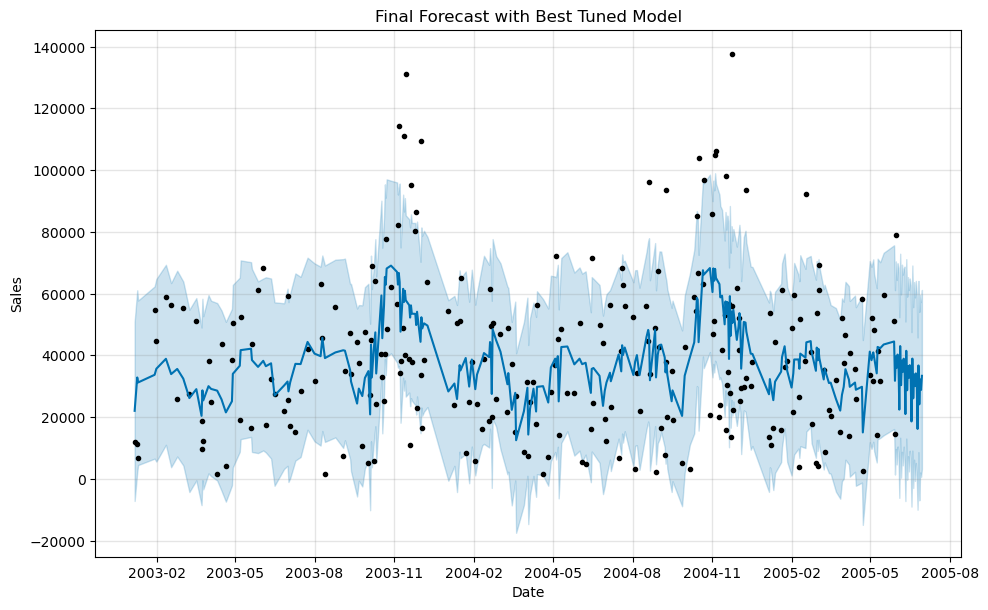

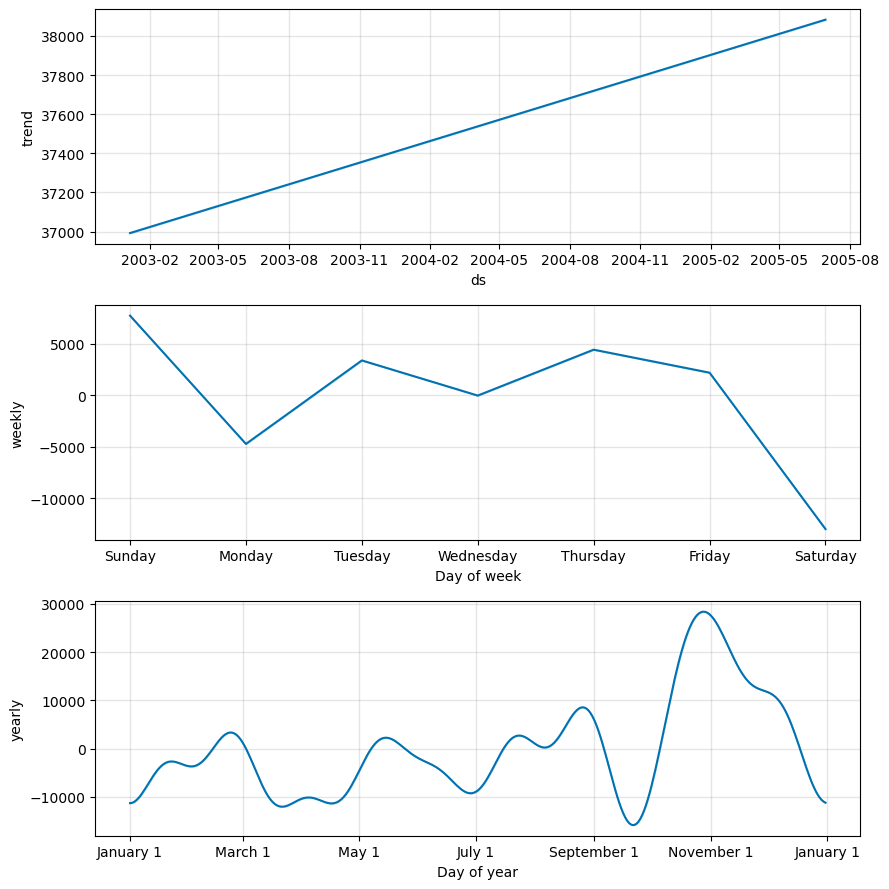

In [41]:
# Retrain model with best parameters
best_model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=1.0,
    seasonality_mode='additive'
)
best_model.fit(df_grouped)

# Forecast future (e.g., next 30 days)
future = best_model.make_future_dataframe(periods=30)
forecast = best_model.predict(future)

# Plot forecast
fig1 = best_model.plot(forecast)
plt.title('Final Forecast with Best Tuned Model')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Plot trend and seasonality components
fig2 = best_model.plot_components(forecast)
plt.show()

In [42]:
# Prepare evaluation (actual vs. predicted on last 30 days)
train = df_grouped.iloc[:-30]
test = df_grouped.iloc[-30:]

# Use forecasted values for test set
forecast_df = forecast[['ds', 'yhat']].set_index('ds')
test_df = test.set_index('ds')
comparison = test_df.join(forecast_df, how='left')

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

comparison = comparison.dropna(subset=['yhat'])

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

print(f"Evaluation on hold-out test set:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")

Evaluation on hold-out test set:
MAE: 14286.38
RMSE: 17162.29


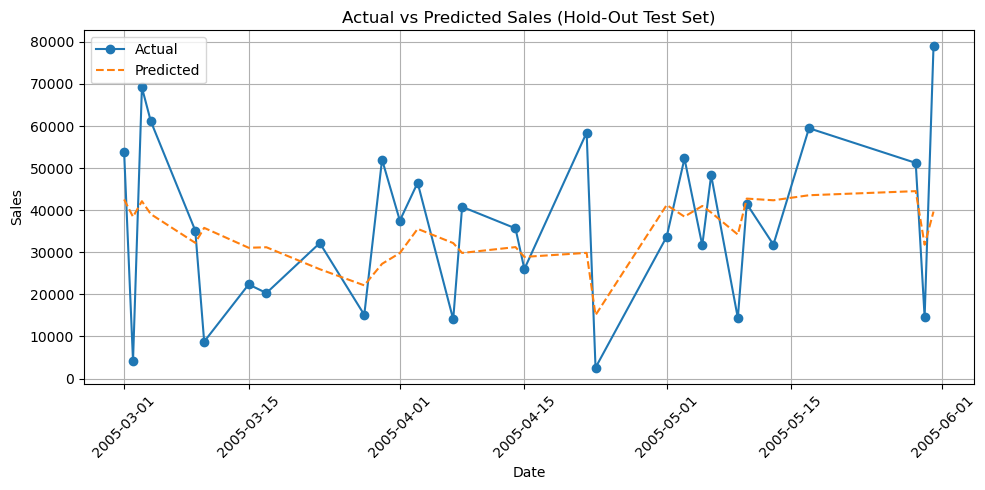

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(comparison.index, comparison['y'], label='Actual', marker='o')
plt.plot(comparison.index, comparison['yhat'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (Hold-Out Test Set)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

18:23:29 - cmdstanpy - INFO - Chain [1] start processing
18:23:29 - cmdstanpy - INFO - Chain [1] done processing


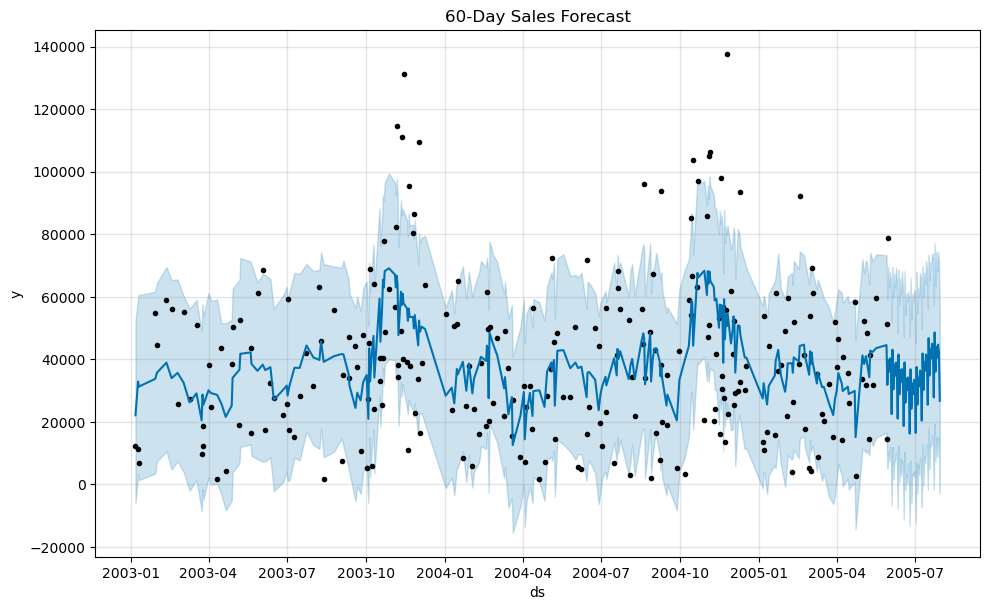

In [44]:
final_model = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=1.0,
    seasonality_mode='additive'
)
final_model.fit(df_grouped)
future = final_model.make_future_dataframe(periods=60)
forecast = final_model.predict(future)
final_model.plot(forecast)
plt.title('60-Day Sales Forecast')
plt.show()